In [77]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 100)
from tqdm import tqdm

In [78]:
import collections
import json 

uniprot_dict = collections.defaultdict(dict)

with open("../uniprotkb_proteome_UP000005640_2024_06_17.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
        uniprot_id = record.id.split("|")[1]
        uniprot_dict[uniprot_id]['seq'] = str(record.seq)


In [79]:

uniprot_matches_data = dict()
missing_count = 0
missing_files = []
for uniprot_id in uniprot_dict:
    match_file = f"/biodata/franco/zsuzsa_lab/loss_T5_human_600aa_1200aa_n1000/{uniprot_id}.json"
    if os.path.exists(match_file):
        with open(match_file) as f:
            tmp_data = json.load(f)
        uniprot_matches_data[uniprot_id] = tmp_data[uniprot_id]['aamask_1']['match']
    else:
        missing_files.append((uniprot_id, match_file))
        missing_count += 1
print(f"Missing {missing_count} files")


Missing 82107 files


In [80]:
print(len(list(uniprot_matches_data.keys())))

for uid, ufile in missing_files:
    if os.path.exists(f"/biodata/franco/zsuzsa_lab/loss_T5_human_600aa_1200aa_n1000/{uid}.json"):
        print(f"File {uid} is there")

411


In [81]:
## find out which uniprots in this analysis are also in disprot

disprot_dict = collections.defaultdict(dict)

with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
            disprot_dict[record.id]['seq'] = str(record.seq)

counter = 0
for uid in list(uniprot_matches_data.keys()):
    if uid in disprot_dict:
        del uniprot_matches_data[uid]
        counter += 1

print(f"{counter} sequences were in Disprot and were removed from the analysis")

25 sequences were in Disprot and were removed from the analysis


In [82]:
aa_vocabulary = "ACDEFGHIKLMNPQRSTVWY"
aa_vocab_list = list(aa_vocabulary)
AA2num = dict(zip(sorted(list(set([i for i in aa_vocabulary]))),np.arange(20)))
AA2num['</s>'] = 20
AA2num['X'] = 21
num2AA = dict(zip(np.arange(20),sorted(list(set([i for i in aa_vocabulary])))))
num2AA[20] = "</s>"
num2AA[21] = "X"
print(len(aa_vocab_list))


20


In [83]:
# Contains mismatches for each sequence, in the format of a dict with relative positiones of each mismatch
# 0-based indexing, mismatch at the masked position +1 position forwards, -1 backwards
# With this, then I can then stratify by protein length and disorder content the mismatch counts and distances to mask!
mismatch_count_dict = dict()
wrong_aa = list()
not_valid_aa = list()

for uniprot_id in tqdm(uniprot_matches_data.keys()):
    seq = uniprot_dict[uniprot_id]['seq']
    matches = uniprot_matches_data[uniprot_id]

    mismatch_count_dict[uniprot_id] = collections.defaultdict(int)
    assert len(matches) == len(seq)
    for current_pos, match in enumerate(matches):

        #check if match is bool or list
        if type(match) == bool:
            ## this entire sequence was predicted accurately
            pass
        else:
            for m in match:
                mismatch_pos, aa_predicted, aa_orig = m
                if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                    not_valid_aa.append((uniprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                if aa_orig != seq[mismatch_pos]:
                    wrong_aa.append((uniprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                relative_pos = mismatch_pos - current_pos
                mismatch_count_dict[uniprot_id][relative_pos] += 1

100%|██████████| 386/386 [00:00<00:00, 406.55it/s]


In [84]:
print(wrong_aa)
print(not_valid_aa)

[]
[('H0YBP1', 0, 'X', 'X')]


In [85]:
collapsed_mismatch_count_dict = collections.defaultdict(int)
for uniprot_id in mismatch_count_dict:
    for k in mismatch_count_dict[uniprot_id]:
        collapsed_mismatch_count_dict[k] += mismatch_count_dict[uniprot_id][k]

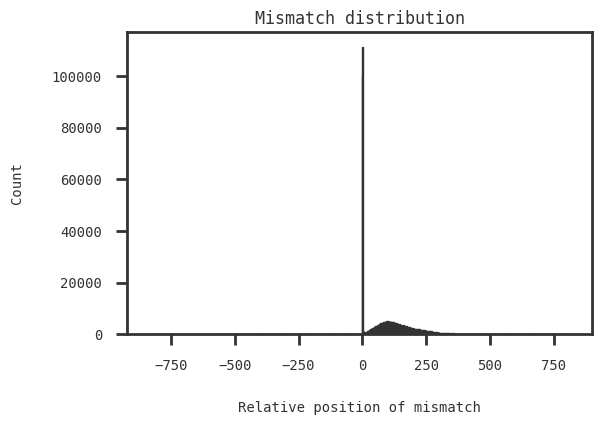

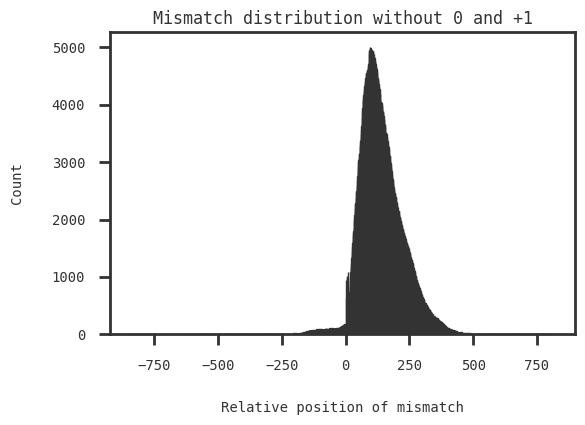

In [86]:
# sort by key and get a list of keys and values
sorted_keys = sorted(collapsed_mismatch_count_dict.keys())
sorted_values = [collapsed_mismatch_count_dict[k] for k in sorted_keys]

ix01 = [i for i,v in enumerate(sorted_keys) if v != 0 and v != 1]

plt.figure(figsize=(6, 4))
plt.bar(sorted_keys, sorted_values)
plt.xlabel("Relative position of mismatch")
plt.ylabel("Count")
plt.title("Mismatch distribution")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar([sorted_keys[i] for i in ix01], [sorted_values[i] for i in ix01])
plt.xlabel("Relative position of mismatch")
plt.ylabel("Count")
plt.title("Mismatch distribution without 0 and +1")
plt.show()


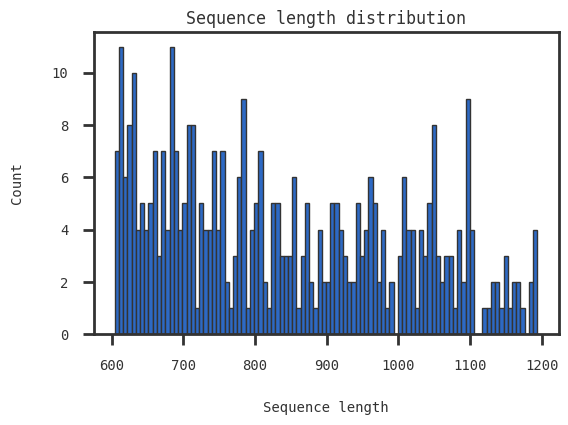

In [87]:
uniprot_lengths = []
for uniprot_id in uniprot_dict.keys():
    if uniprot_id in uniprot_matches_data:
        uniprot_lengths.append(len(uniprot_dict[uniprot_id]['seq']))

plt.figure(figsize=(6, 4))
plt.hist(uniprot_lengths, bins=100)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Sequence length distribution")
plt.show()


In [88]:
df = pd.DataFrame([])
len_binsize = 100
for uniprot_id in mismatch_count_dict:
    temp_list = list()
    protlen = len(uniprot_dict[uniprot_id]['seq'])
    len_bin = int(np.floor(protlen/len_binsize)*len_binsize)
    for k in mismatch_count_dict[uniprot_id]:
        temp_list.append([uniprot_id, k, mismatch_count_dict[uniprot_id][k], protlen, len_bin])
    df = pd.concat([df, pd.DataFrame(temp_list, columns = ['uniprot_id', 'relative_pos', 'count', 'protlen', 'len_bin'])])

In [89]:

df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]

df_no01_crop = df_no01[df_no01['len_bin'] >700]
df_no01_crop['uniprot_id'].nunique()

173

[600, 700, 800, 900, 1000, 1100]


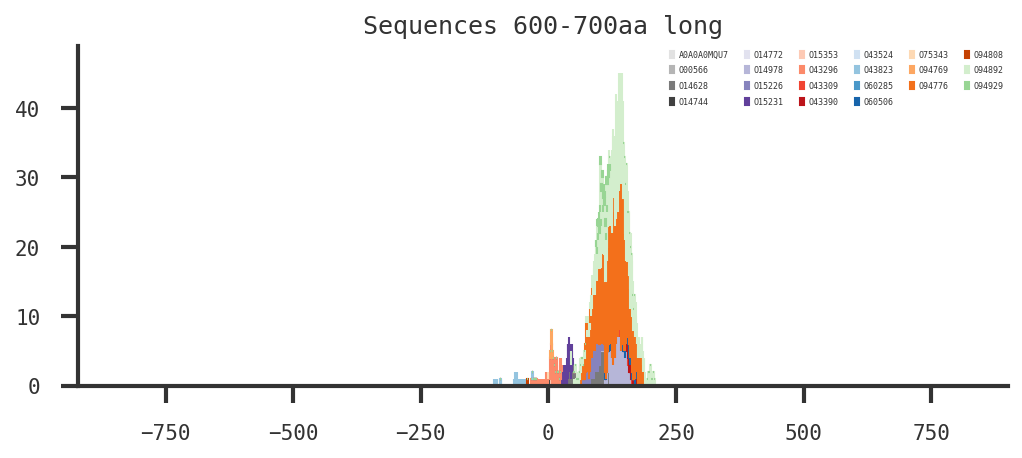

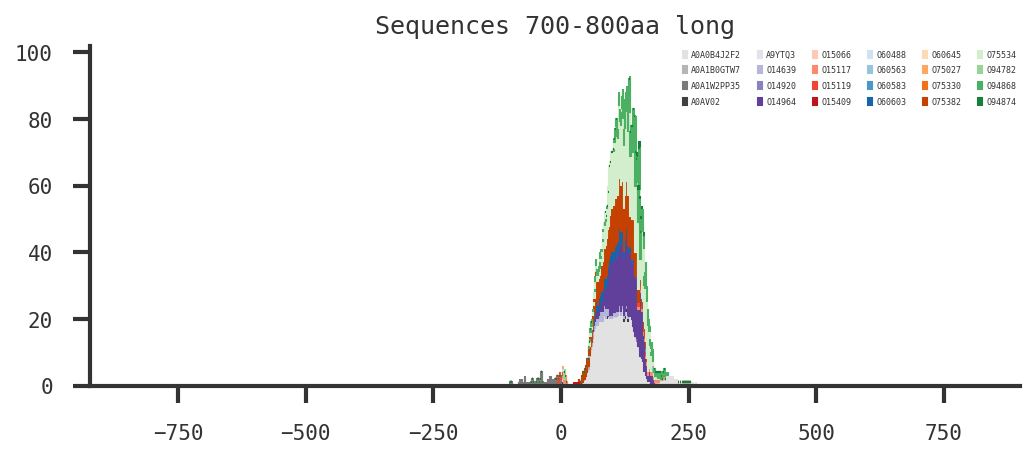

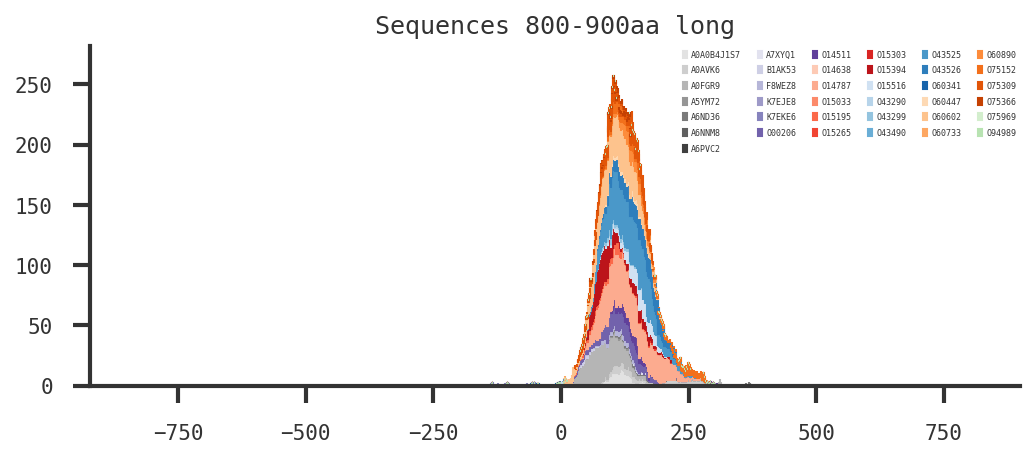

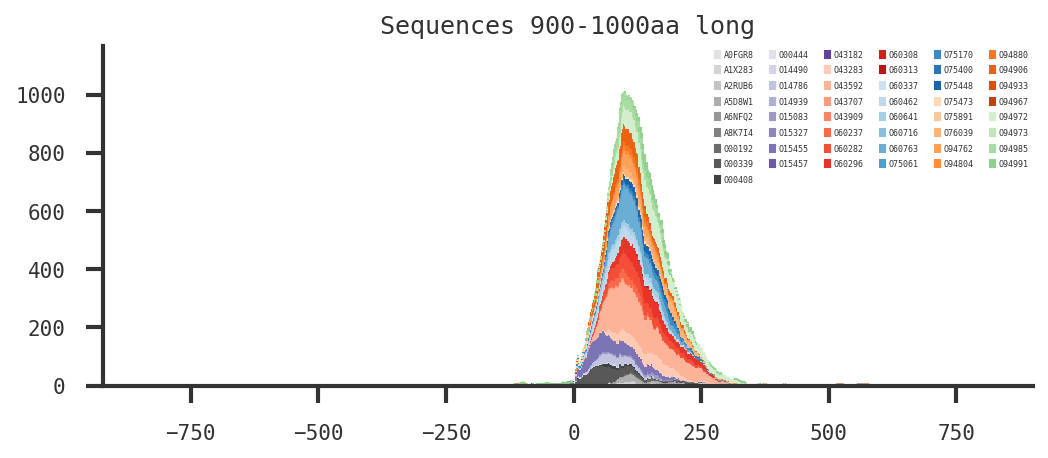

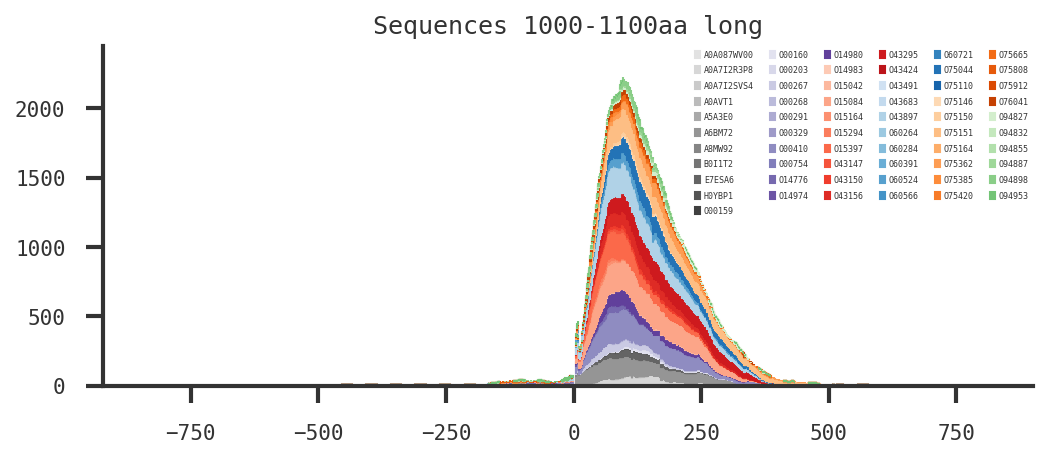

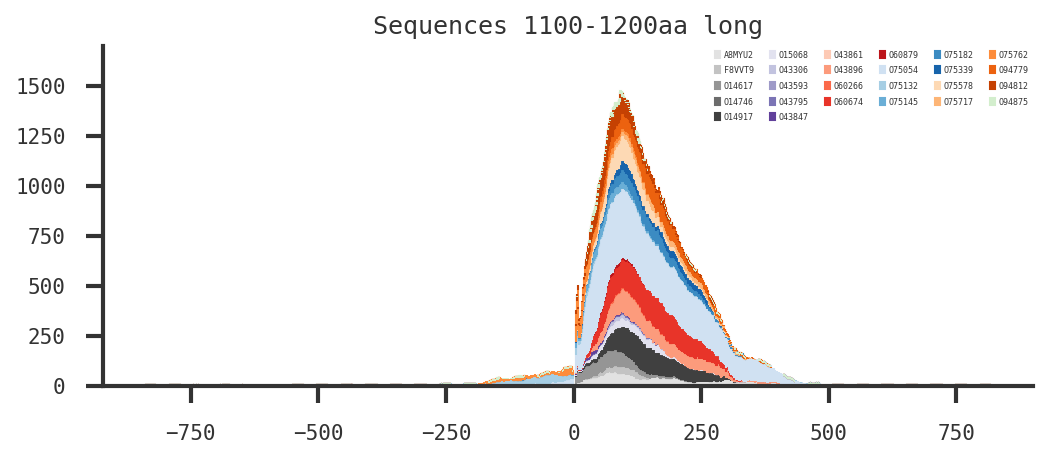

In [90]:
import seaborn as sns
import matplotlib

df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]

len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)

N = 10 # number of colors to extract from each of the base_cmaps below

base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']

n_base = len(base_cmaps)

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())
for len_bin in len_bins:
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    #ax = axes[len_bins.index(len_bin)]

    uniprot_ids = df_no01_crop['uniprot_id'].unique()

    N = int(np.ceil(len(uniprot_ids)/len(base_cmaps)))
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    colors = np.concatenate([matplotlib.colormaps[name](np.linspace(0.2,0.8,N)) for name in base_cmaps])
    cmap = matplotlib.colors.ListedColormap(colors)

    bottom = np.zeros(len(relative_pos))
    # for each uniprot_id, make a vector of the height value at each relative_pos
    all_bardata = list()
    for j, did in enumerate(uniprot_ids):
        did_vector = np.zeros(len(relative_pos))
        for i,row in df_no01_crop[df_no01_crop.uniprot_id == did].sort_values("relative_pos").iterrows():
            did_vector[relative_pos.index(row["relative_pos"])] = row["count"]
        ax.bar(relative_pos, did_vector, width, label=did, bottom=bottom, color=cmap(j), edgecolor=cmap(j))
        ax.legend(ncol=len(base_cmaps), prop={'size': 4})
        
        # eliminate axis borders
        bottom += did_vector

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+int(ymax*0.1))
    ax.set_title(f"Sequences {len_bin}-{len_bin+len_binsize}aa long")
    plt.show()


[600, 700, 800, 900, 1000, 1100]


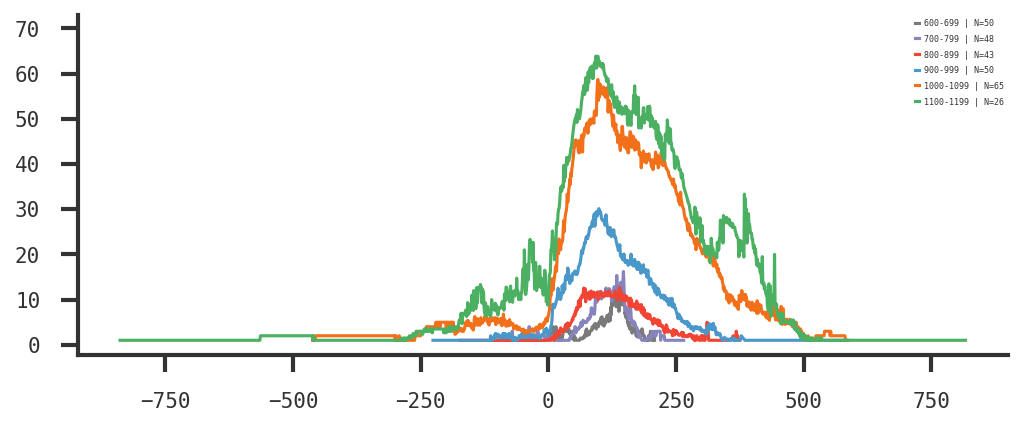

In [91]:
import seaborn as sns
import matplotlib

### Same idea of plot above, but get the average mismatch counts for each relative_pos
### and plot those averages for each length bin in the same plot

#df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) & (df['relative_pos'] != 2) & (df['relative_pos'] != 3)]

df_no01 = df[(df['relative_pos'] != 0) & (df['relative_pos'] != 1) ]

len_bins = sorted(df_no01['len_bin'].unique())
print(len_bins)

mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 10, colors = 'banskt', dpi = 150)

base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']

# find all the available "relative_pos" 
relative_pos = sorted(df_no01['relative_pos'].unique())

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

for i, len_bin in enumerate(len_bins):
    
    width = 0.5
    df_no01_crop = df_no01[df_no01['len_bin'] == len_bin]
    df_avg = df_no01_crop.groupby('relative_pos').mean("count")
   
    # we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
    name = base_cmaps[i]
    color = matplotlib.colormaps[name](0.6)
    ax.plot(df_avg.index.values, df_avg['count'].values, label=f"{len_bin}-{len_bin+len_binsize-1} | N={len(df_no01_crop['uniprot_id'].unique())}", color=color)

ax.legend(prop={'size': 4})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax+int(ymax*0.1))

plt.show()



In [92]:
print(len(df_no01['uniprot_id'].unique()))
print(len(df['uniprot_id'].unique()))

df_01 = df[(df['relative_pos'] == 0) | (df['relative_pos'] == 1) | (df['relative_pos'] == 2) | (df['relative_pos'] == 3)]
print(len(df_01["uniprot_id"].unique()))


282
386
386


In [93]:
uniprot_ids_nolongrangeMM  = list(set(df_01["uniprot_id"].unique()) - set(df_no01['uniprot_id'].unique()))

df[ df['uniprot_id'] == uniprot_ids_nolongrangeMM[0]]

,uniprot_id,relative_pos,count,protlen,len_bin
0,O14829,1,276,653,600
1,O14829,0,259,653,600


<Axes: xlabel='relative_pos', ylabel='Density'>

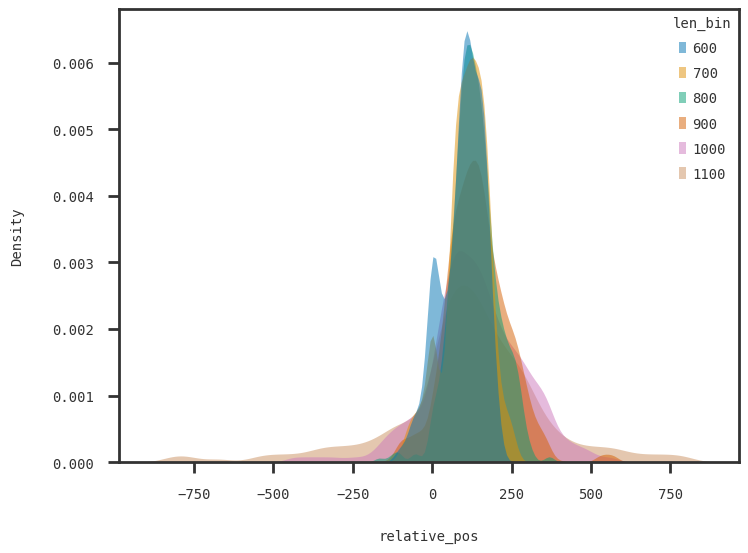

In [94]:
plt.figure(figsize=(8, 6), dpi=100)
sns.kdeplot(data=df_no01, x='relative_pos', hue='len_bin', fill=True, 
            common_norm=False, common_grid=True, palette="colorblind",
            alpha=.5, linewidth=0)

In [95]:
wrong_aa = list()
not_valid_aa = list()

mismatch_count_matrix = np.zeros((1200,1200))

for uniprot_id in tqdm(uniprot_matches_data.keys()):
    seq = uniprot_dict[uniprot_id]['seq']
    matches = uniprot_matches_data[uniprot_id]

    assert len(matches) == len(seq)
    for current_pos, match in enumerate(matches):

        #check if match is bool or list
        if type(match) == bool:
            ## this entire sequence was predicted accurately
            pass
        else:
            for m in match:
                mismatch_pos, aa_predicted, aa_orig = m
                if (aa_orig not in aa_vocab_list) or (seq[mismatch_pos] not in aa_vocab_list):
                    not_valid_aa.append((uniprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                if aa_orig != seq[mismatch_pos]:
                    wrong_aa.append((uniprot_id, mismatch_pos, aa_orig, seq[mismatch_pos]))
                    continue
                
                relative_pos = mismatch_pos - current_pos
                if np.abs(relative_pos) > 3:
                    mismatch_count_matrix[current_pos, mismatch_pos] += 1

  0%|          | 0/386 [00:00<?, ?it/s]

100%|██████████| 386/386 [00:02<00:00, 183.30it/s]


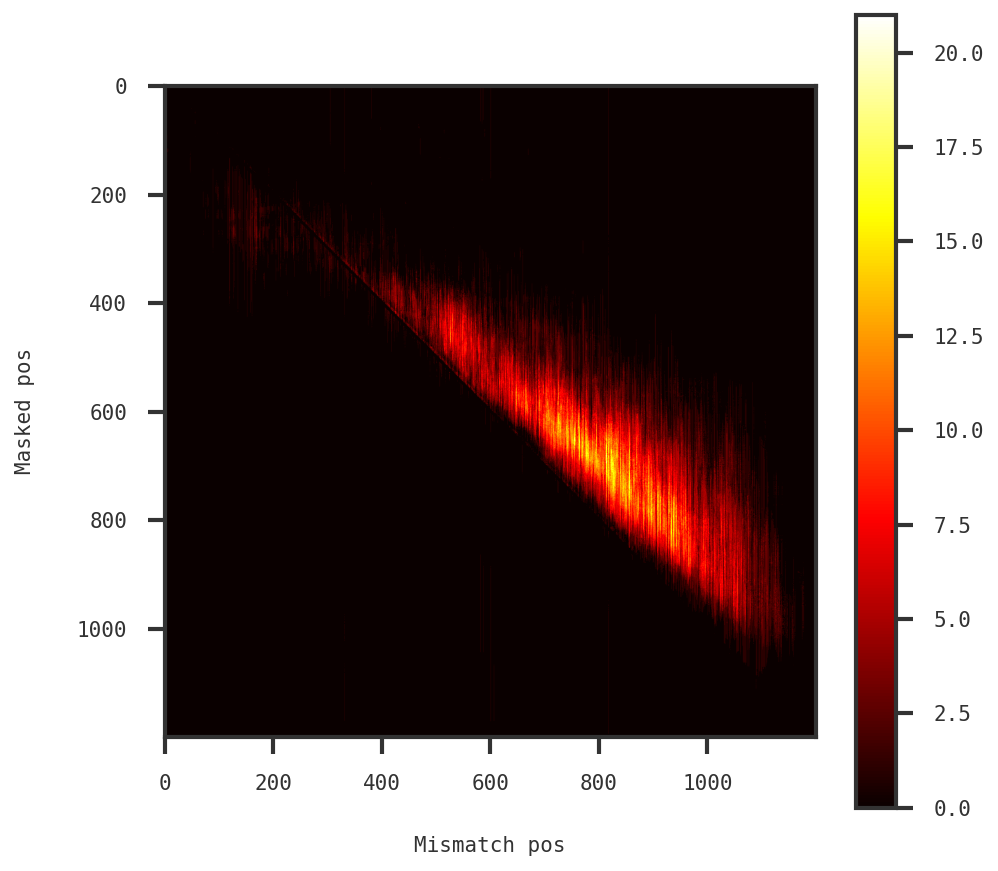

In [96]:
fig = plt.figure(figsize=(7, 7), dpi=150)
plt.imshow(mismatch_count_matrix, cmap='hot')
plt.colorbar()
plt.ylabel("Masked pos")
plt.xlabel("Mismatch pos")
plt.show()


In [97]:
import seaborn as sns

dfmat = pd.DataFrame(mismatch_count_matrix)
sns.kdeplot( data=geyser, x="waiting", y="duration", hue="kind", fill=True,
)

NameError: name 'geyser' is not defined

In [ ]:
####### OLD CODE
# match_counts         = np.zeros(AAsize)     # nº of matches
# mismatch_counts_aa   = np.zeros(AAsize)     # nº of total mismatches, could be more than 1 mismatch per masked aa
# mismatch_in_disorder = np.zeros(AAsize)
# mismatch_in_order    = np.zeros(AAsize)
# match_in_disorder = np.zeros(AAsize)
# match_in_order    = np.zeros(AAsize)
# match_in_order_pos    = list()
# match_in_disorder_pos = list()

# mismatch_mask_counts = np.zeros(AAsize)     # nº of mismatches per masked aa, one count per masked embedding
# mismatch_matrix             = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_disorder = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_order    = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_disorder_onsite = np.zeros((AAsize,AAsize))
# mismatch_matrix_in_order_onsite    = np.zeros((AAsize,AAsize))
# mismatch_posdiff = list()        # distance of the masked aa to the mismatched position (can separate long and short)
# mismatch_posdiff_detail = list() # uniprot, masked aa pos, mismatch pos, prot length
# n_pos_mismatch = collections.defaultdict(int) # nº of times a position was mismatched (on different masked aa)
# n_mismatch_pos = collections.defaultdict(int) # nº of mismatches encountered for a single masked aa
# loss_match    = list()
# loss_mismatch = list()
# loss_mismatch_in_order = list()
# loss_mismatch_in_disorder = list()
# onsm_offsmm = list() #on-site match but off-site mismatch
# for unip in datadict:
#     L = len(datadict[unip]['seq'])
#     this_seq = datadict[unip]['seq']
#     diso_ix = [True if e != "-" else False for e in datadict[unip]['disorder'] ]
#     loss = np.array(datadict[unip]['aamask_1']['loss'])
#     matches = datadict[unip]['aamask_1']['match']
#     seq_pos = np.arange(len(matches))
#     #print(list(zip(seq_pos, matches)))
#     for pos,e in enumerate(matches):
#         if e == True:
#             match_counts[AA2num[this_seq[pos]]] += 1
#             loss_match.append([loss[pos], L])
#             if diso_ix[pos]: # in disordered region
#                 match_in_disorder[AA2num[this_seq[pos]]] += 1
#                 match_in_disorder_pos.append(f"{unip}_{pos}")
#             else:
#                 match_in_order[AA2num[this_seq[pos]]] += 1
#                 match_in_order_pos.append(f"{unip}_{pos}")
#         else:
#             mismatch_mask_counts += 1
#             loss_mismatch.append([loss[pos], L])
#             n_mismatch_pos[f"{unip}_{pos}"] += len(e)
#             this_pos_found = False
#             for mismatch_aa in e:
#                 diff = mismatch_aa[0] - pos
#                 mismatch_posdiff.append(diff)
#                 mismatch_posdiff_detail.append([unip,pos,mismatch_aa[0],L])
#                 mismatch_counts_aa[AA2num[mismatch_aa[2]]] += 1
#                 n_pos_mismatch[f"{unip}_{mismatch_aa[0]}"] += 1
#                 mismatch_matrix[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                 if diso_ix[mismatch_aa[0]]:
#                     mismatch_matrix_in_disorder[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                     mismatch_in_disorder[AA2num[mismatch_aa[2]]] += 1
#                     if pos == mismatch_aa[0]:
#                         mismatch_matrix_in_disorder_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                         loss_mismatch_in_disorder.append(loss[pos]* L)
#                         this_pos_found = True
#                 else:
#                     mismatch_matrix_in_order[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                     mismatch_in_order[AA2num[mismatch_aa[2]]] += 1
#                     if pos == mismatch_aa[0]:
#                         loss_mismatch_in_order.append(loss[pos]* L)
#                         mismatch_matrix_in_order_onsite[AA2num[mismatch_aa[2]],AA2num[mismatch_aa[1]]] += 1
#                         this_pos_found = True
#             if not this_pos_found:
#                 ## on-site match but off-site mismatch!!
#                 match_counts[AA2num[this_seq[pos]]] += 1
#                 if diso_ix[pos]:
#                     match_in_disorder[AA2num[this_seq[pos]]] += 1
#                 else:
#                     match_in_order[AA2num[this_seq[pos]]] += 1
#                 onsm_offsmm.append([unip,pos])